<a href="https://colab.research.google.com/github/RishabhNegi1/Spam-Vs-No-Spam/blob/main/Mail_Spam_Classifier(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.9 MB/s eta 0:00:00


Saving spam.csv to spam.csv
Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 561s 20s/step - accuracy: 0.6449 - loss: 0.6516 - precision: 0.6441 - recall: 0.6756 - val_accuracy: 0.5938 - val_loss: 0.6109 - val_precision: 0.9412 - val_recall: 0.2645
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 549s 20s/step - accuracy: 0.7474 - loss: 0.5493 - precision: 0.7858 - recall: 0.6608 - val_accuracy: 0.8259 - val_loss: 0.4987 - val_precision: 0.8727 - val_recall: 0.7934
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 511s 18s/step - accuracy: 0.8259 - loss: 0.4791 - precision: 0.8253 - recall: 0.8192 - val_accuracy: 0.8750 - val_loss: 0.4388 - val_precision: 0.8394 - val_recall: 0.9504
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 559s 18s/step - accuracy: 0.8484 - loss: 0.4472 - precision: 0.8256 - recall: 0.8580 - val_accuracy: 0.8795 - val_loss: 0.4029 - val_precision: 0.8507 - val_recall: 0.9421
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 562s 18s/step - accuracy: 0.8718 - loss: 0.3865 - precision: 0.8815 - recall: 0.8507 - val_accuracy

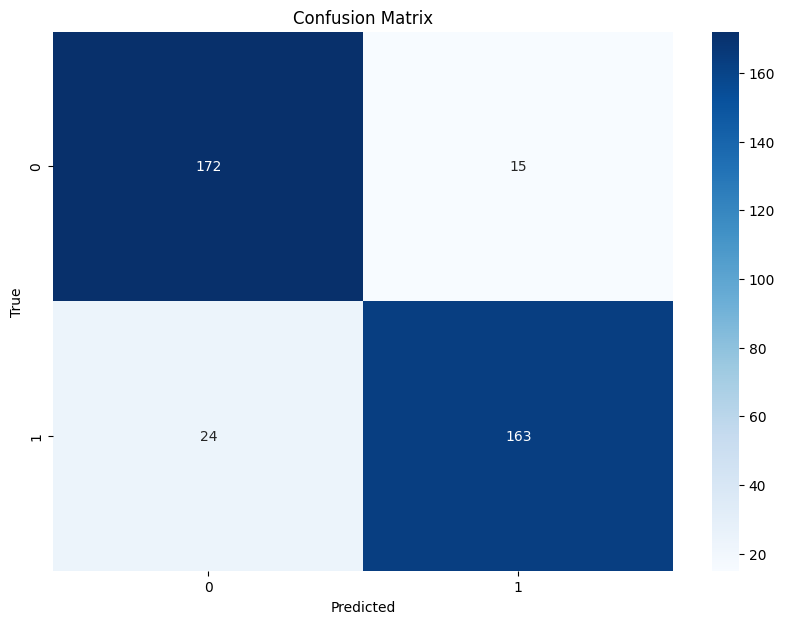

ValueError: Invalid dtype: str4896

In [1]:
# Install necessary libraries
!pip install tensorflow tensorflow-hub tensorflow-text

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import files

# Upload the dataset
uploaded = files.upload()

# Load the dataset
df = pd.read_csv(next(iter(uploaded)))

# Preprocess the data
df['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0], random_state=42)
df_balanced = pd.concat([df_ham_downsampled, df_spam]).reset_index(drop=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                    stratify=df_balanced['spam'], random_state=42)

# Define custom layer for BERT
class BertLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(BertLayer, self).__init__()
        with tf.device('/CPU:0'):  # Force BERT layers to run on CPU
            self.bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
            self.bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

    def call(self, inputs):
        preprocessed = self.bert_preprocess(inputs)
        return self.bert_encoder(preprocessed)['pooled_output']

# Build the model
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    bert_layer = BertLayer()(text_input)
    dropout = tf.keras.layers.Dropout(0.1, name="dropout")(bert_layer)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout)
    return tf.keras.Model(inputs=[text_input], outputs=[output])

# Build the model
model = build_classifier_model()

# Compile the model
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=32)

# Evaluate the model
y_predicted = model.predict(X_test)
y_predicted = np.where(y_predicted > 0.5, 1, 0)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_predicted))

# Plot confusion matrix
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow?',
    "Why don't you wait 'til at least Wednesday to see if you get your."
]

# Convert the list of reviews to a NumPy array
reviews_array = np.array(reviews)

# Make predictions
predictions = model.predict(reviews_array)

# Convert predictions to 'spam' or 'ham'
predictions = np.where(predictions > 0.5, 'spam', 'ham')

# Print the results
for review, prediction in zip(reviews, predictions):
    print(f'Review: {review}\nPrediction: {prediction}\n')

